# Running a Dynamical Decoupling Sequence on Cirq

Q-CTRL Open Controls provides easy-to-use methods to construct Dynamical Decoupling Sequences (DDS) according to well-known dynamical decoupling schemes. This is described in the [creating a DDS notebook](creating_a_dds.ipynb). Here we show how a DDS from Q-CTRL Open Controls can be exported to a `cirq.Circuit` to run in `cirq.Simulator`.

Note : You can install `cirq` by simply running `pip install cirq`. Please consult [Cirq Documentation](https://cirq.readthedocs.io/en/stable/) for installation instruction and general introduction to `cirq` package.

## Imports

In [1]:
#General

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#Q-CTRL Open Controls
from qctrlopencontrols import new_predefined_dds, convert_dds_to_cirq_circuit

#Cirq
import cirq

## Running a DDS on a Cirq Simulator

This section demonstrates how a DDS can be prepared and a corresponding `cirq.Circuit` made and executed on a `cirq` simulator (`cirq.Simulator`).

Q-CTRL Open Controls defines a DDS as a set of instantaneous unitary operations performed at specific offset times, see the [technical documentation](https://docs.q-ctrl.com/control-library#dynamical-decoupling-sequences) for mathematical details.

`cirq` implements quantum computation through a series of [gates](https://cirq.readthedocs.io/en/stable/gates.html). Standard way to create a circuit is through `cirq.Circuit` that accepts a list of valid gates. If a user wants to add pauses (in time) during a computation they can use identity gates. Alternatively, `cirq` provides `ScheduledOperation` that specifies an operation (application of a gate operating on one more qubits) at a certain instant measured in "nano-seconds" or "pico-seconds" from the start of the sequence. A list of `ScheduledOperation` is collated by `cirq.Schedule`. Both `cirq.Circuit` and `cirq.Schedule` can be used in `cirq.Simulator` to simulate the circuit. We provide a `circuit_type` option to select between `cirq.Circuit` and `cirq.Schedule` as desired output from the conversion method.

Converting a DDS into a `cirq` circuit is an approximate process where the instantaneous unitaries are replaced with finite duration gates. Morver, in `cirq.Circuit`, the pauses in-between unitaries are replaced with the closest integer number of identity gates. The exact algorithm used to make this approximation is documented in the [source code](../qctrlopencontrols/cirq/cirq_circuit.py).

In this example we will define a Quadratic DDS and convert it into a circuit that we can later run on a simulator. See [creating_a_DDS.ipynb](creating_a_DDS.ipynb) to see how other sequences can be created.

### Preparing the Sequences

In [2]:
## Quadratic sequence, total duration: 20us
quadratic_sequence = new_predefined_dds(
    scheme='quadratic',
    duration=20e-6, 
    number_inner_offsets=2,
    number_outer_offsets=2,
    name='Quadratic sequence')
print(quadratic_sequence)


Quadratic sequence:
Duration = 2e-05
Offsets = [0.0,0.06249999999999998,0.18749999999999994,0.24999999999999994,0.37499999999999994,0.6249999999999999,0.7499999999999999,0.8124999999999999,0.9375,1.0] x 2e-05
Rabi Rotations = [0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0] x pi
Azimuthal Angles = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0] x pi
Detuning Rotations = [0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0] x pi


### Constructing the Circuit Using Q-CTRL Open Controls

To construct a circuit/schedule from a DDS, we need to provide the DDS (`dynamic_decoupling_sequence`). You can also provide a list of target qubits (each of `cirq.Qid` type) to indicate qubits on which the DDS will be applied. `gate_time` is the delay (in seconds) introduced by each of the gates. If measurement is required, use `add_measurement=True`.

See the [source code](../qctrlopencontrols/cirq/cirq_circuit.py) for more information and other parameters that may be useful.

In this example, we will use the default single qubit on 1-D lattice and $X_{\pi/2}$ rotation as the pre-post gate. We specify the `gate_time` to be $0.4$ $\mu$s. Finally we will add a measurement operation. In this example we will convert the DDS into a `cirq.Circuit`.

In [3]:
## Prepare the conversion related parameters
'''
gate_time : float
    Time delay (in seconds) introduced by identity gate
'''
gate_time = 0.4e-6

'''
add_measurement : bool
    Indicates if the circuit requires a measurement step.
    Required for 'qasm_simulator' and real device backends
'''
add_measurement = True

'''
circuit_type : str
    One of 'scheduled circuit' (convert to cirq.Schedule) or 
    'standard circuit' (convert to cirq.Circuit). See source code
    documentation for more details.
'''
circuit_type = 'standard circuit'


## convert the quadratic sequence to cirq.Circuit
quadratic_cirq_circuit = convert_dds_to_cirq_circuit(
    dynamic_decoupling_sequence=quadratic_sequence,
    gate_time=gate_time,
    add_measurement=add_measurement,
    circuit_type=circuit_type
)

### Plotting the DDS

We can use Q-CTRL Open Controls to plot the DDS for comparison against its `cirq` circuit approximations.

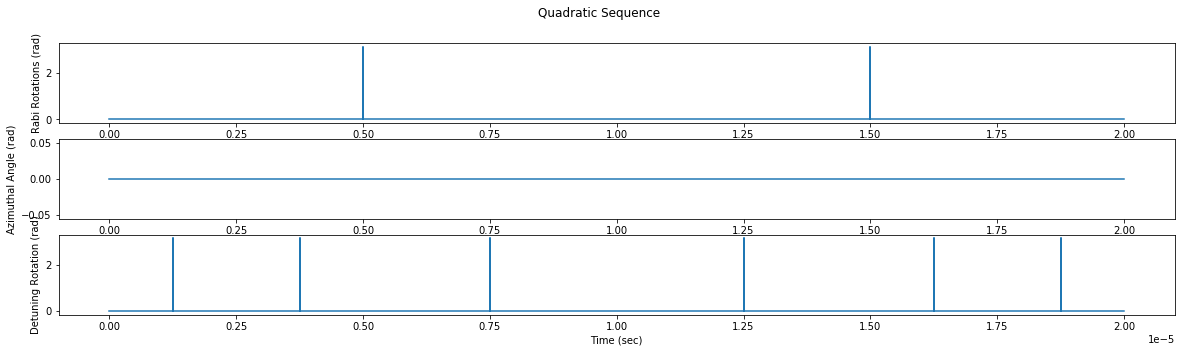

In [4]:
formatted_plot_data = quadratic_sequence.get_plot_formatted_arrays()
rabi_rotations, azimuthal_angles, detuning_rotations, times = (
    formatted_plot_data['rabi_rotations'],
    formatted_plot_data['azimuthal_angles'],
    formatted_plot_data['detuning_rotations'],
    formatted_plot_data['times']
)

# prepare the axes
figure, (rabi_plot_axis, azimuth_plot_axis, detuning_plot_axis) = plt.subplots(
    3, 1, figsize=(20,5))

rabi_plot_axis.plot(times, rabi_rotations)
rabi_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
rabi_plot_axis.set_xlabel('Time (sec)')
rabi_plot_axis.set_ylabel('Rabi Rotations (rad)')

azimuth_plot_axis.plot(times, azimuthal_angles)
azimuth_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
azimuth_plot_axis.set_xlabel('Time (sec)')
azimuth_plot_axis.set_ylabel('Azimuthal Angle (rad)')

detuning_plot_axis.plot(times, detuning_rotations)
detuning_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
detuning_plot_axis.set_xlabel('Time (sec)')
detuning_plot_axis.set_ylabel('Detuning Rotation (rad)')

plt.suptitle('Quadratic Sequence')
plt.show()

### Printing the Circuit

We can print a `cirq.Circuit` generated by Q-CTRL Open Controls.

Note that both DDS will be applied with $X_{\pi/2}$ rotations at beginning and end, that is, at offsets of $[0, 20]$ $\mu$s, to create the desired superposition state. The $X_{\pi/2}$ rotations are not part of the DDS objects but are added to the circuits in the form of pre-post-gates that are implemented via `cirq.SingleQubitGate`. The `SingleQubitGate` is specified by a $2\times 2$ unitary matrix. In this case, the following unitary matrix (corresponding to $X_{\pi/2}$ rotation) is supplied as default by the conversion method.

$$
\frac{1}{\sqrt{2}}\times\begin{bmatrix}1 & -1j\\-1j & 1\end{bmatrix}
$$

The $Rz(\pi)$ gates are $Z_\pi$ pulses (a $\pi$ rotation around $Z$-axis) and $Rx(\pi)$ gates correspond to $X_{\pi}$ pulses (a $\pi$ rotation around $X$-axis). The gates match the pulses in the DDS.

The `Id` in the drawing corresponds to the `identity` gate. In the DDS, the first $Z_{\pi}$-pulse is applied at a delay of $1.25$ $\mu$s. This is approximated by introducing 3-`Id` gates with a delay of $0.4\times 3=1.2$ $\mu$s. Application of $Z_{\pi}$ pulse will take another $0.4\mu$s. Similarly, the second set of 5 `Id` gates introduces a delay of $2$ $\mu$s close to the actual delay of $3.75-1.65=2.10$ microseconds.

At the end of each circuit, we place a `measurement` ($M$) operator to read out the result.

In [5]:
##Printing the Quadratic Circuit
print(quadratic_cirq_circuit)

      ┌                         ┐                                                                                                                                                                                                                                           ┌                         ┐
0: ───│0.707+0.j    0.   -0.707j│───I───I───I───I───Rz(π)───I───I───I───I───I───Rz(π)───I───I───Rx(π)───I───I───I───I───I───Rz(π)───I───I───I───I───I───I───I───I───I───I───I───Rz(π)───I───I───I───I───I───Rx(π)───I───I───Rz(π)───I───I───I───I───I───Rz(π)───I───I───I───│0.707+0.j    0.   -0.707j│───M('qubit-0')───
      │0.   -0.707j 0.707+0.j   │                                                                                                                                                                                                                                           │0.   -0.707j 0.707+0.j   │
      └                         ┘                                                             

### Run the Circuit on Cirq Simulator using Cirq API

Consult [Simulation](https://cirq.readthedocs.io/en/stable/simulation.html) for a description of available simulation APIs and their respective properties. Here, we will use the `run` method of `cirq.Simulator` to run the circuit. The circuit is run multiple times upto `repetitions` times. The result is printed after the simulation.

In [6]:
## Prepares the simulator parameters
'''
repetitions : int
    The number of times the circuit will be executed
'''
repetitions = 100

simulator = cirq.Simulator()
result = simulator.run(quadratic_cirq_circuit, repetitions=repetitions)

#print the outcome of each repetition
print(result)

#you can also collect the outcome as histogram (calculated as dict)
print(result.histogram(key=['qubit-0']))

qubit-0=1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
Counter({1: 100})
